<h1> Test Run </h1>

<h3> Code Cleaning </h3>

In [2]:
import pandas as pd

# Load the Excel file
file_path = "./Excel files/2023-2024 Plan for Dept Heads.xlsx"
xls = pd.ExcelFile(file_path)

# Load the 2nd tab with header at the correct row
df_spring_2023 = pd.read_excel(xls, sheet_name='Spring 2023', header=2)

# Load the 3rd tab, skip the first two rows, and then set the correct header row
df_fall_2022 = pd.read_excel(xls, sheet_name='Fall 2022', skiprows=2)
df_fall_2022.columns = df_fall_2022.iloc[0]  # Set the correct header
df_fall_2022 = df_fall_2022[1:]  # Skip the header row

# Drop the specified columns
columns_to_drop = ['Estimated NEED', 'Estimated ELIGIBLE', 'Day', 'Start Time', 'End Time', 
                   'Zoom Links (for Hybrid courses and students granted exceptions to attend online ONLY)']
df_spring_2023 = df_spring_2023.drop(columns=columns_to_drop, errors='ignore')
df_fall_2022 = df_fall_2022.drop(columns=columns_to_drop, errors='ignore')

# Drop the first instances of "Day", "Start Time", and "End Time" but keep the second instances
df_spring_2023 = df_spring_2023.loc[:, ~df_spring_2023.columns.duplicated()]
df_fall_2022 = df_fall_2022.loc[:, ~df_fall_2022.columns.duplicated()]

# Remove leading and trailing white spaces from all columns
df_spring_2023 = df_spring_2023.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df_fall_2022 = df_fall_2022.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# List of wanted departments
wanted_departments = [
'COMPUTING', 'BS CIT', 'BS COMPUTING SECURITY', 'MATH/SCIENCE', 'ASC'
]

# Adjusted function to filter the rows based on department names and their courses
def filter_departments_corrected(df, departments, class_col, subject_col, cat_col, sect_col, course_name_col):
    # Initialize an empty DataFrame to store the filtered rows
    filtered_df = pd.DataFrame(columns=df.columns)
    add_row = False

    for _, row in df.iterrows():
        # Check if the row is a department header
        if pd.isna(row[class_col]) and pd.isna(row[subject_col]) and pd.isna(row[cat_col]) and pd.isna(row[sect_col]):
            if row[course_name_col] in departments:
                add_row = True
            else:
                add_row = False
        # Add rows that belong to the wanted departments
        if add_row:
            filtered_df = pd.concat([filtered_df, pd.DataFrame([row], columns=df.columns)], ignore_index=True)

    return filtered_df

# Apply the function to both dataframes with the corrected column names
df_spring_2023_filtered_corrected = filter_departments_corrected(df_spring_2023, wanted_departments, 'Class #', 'Sbjct', 'Crs #', 'Sect#', 'Course Name')
df_fall_2022_filtered_corrected = filter_departments_corrected(df_fall_2022, wanted_departments, 'Class #', 'Subject', 'Cat#', 'Sect#', 'Course Name')

# Save the filtered dataframes to new CSV files
csv_spring_2023_filtered_corrected = 'Spring_2023_Filtered_Corrected.csv'
csv_fall_2022_filtered_corrected = 'Fall_2022_Filtered_Corrected.csv'

df_spring_2023_filtered_corrected.to_csv(csv_spring_2023_filtered_corrected, index=False)
df_fall_2022_filtered_corrected.to_csv(csv_fall_2022_filtered_corrected, index=False)

(csv_spring_2023_filtered_corrected, csv_fall_2022_filtered_corrected)

c:\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\Johnson Maliakal\AppData\Local\Temp\ipykernel_7328\1011399851.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  filtered_df = pd.concat([filtered_df, pd.DataFrame([row], columns=df.columns)], ignore_index=True)


('Spring_2023_Filtered_Corrected.csv', 'Fall_2022_Filtered_Corrected.csv')

<h3> Genetic Algorithm </h3>

In [19]:
import pandas as pd
import random
import pygad

# Function to load and preprocess the courses data
def load_and_preprocess(file_path, semester):
    courses_df = pd.read_csv(file_path)
    if semester == 'spring':
        columns_to_use = ['Sbjct', 'Crs #', 'Sect#', 'Course Name', ' Instructor', 'Days', 'Start Time.1', 'End Time.1', 'Room #']
        courses = courses_df[columns_to_use].reset_index(drop=True)
        courses.columns = ['Subject', 'Cat#', 'Sect#', 'Course Name', 'Instructor', 'Days', 'Time Start', 'Time End', 'Room #']
    elif semester == 'fall':
        columns_to_use = ['Subject', 'Cat#', 'Sect#', 'Course Name', 'Instructor', 'Days', 'Time Start', 'Time End', 'Room #']
        courses = courses_df[columns_to_use].reset_index(drop=True)
    else:
        raise ValueError("Semester must be either 'spring' or 'fall'")
    
    # Mark rows where only the 'Course Name' column is filled and others are missing (department headers)
    courses['IsHeader'] = courses.apply(lambda row: pd.notna(row['Course Name']) and row[['Subject', 'Cat#', 'Sect#', 'Instructor', 'Days', 'Time Start', 'Time End', 'Room #']].isnull().all(), axis=1)
    
    courses = courses.reset_index(drop=True)
    return courses

# Function to decode a chromosome into a schedule
def decode_chromosome(chromosome, courses_cleaned, possible_days, possible_time_slots, possible_lab_days, classrooms):
    schedule = []
    num_courses = len(courses_cleaned)
    for i in range(num_courses):
        if courses_cleaned.iloc[i]['IsHeader']:
            schedule.append(courses_cleaned.iloc[i].drop('IsHeader').to_dict())
            continue
        days_index = int(chromosome[3*i] % 2)
        time_slot_index = int(chromosome[3*i + 1] % len(possible_time_slots))
        classroom_index = int(chromosome[3*i + 2] % len(classrooms))
        days = possible_days[days_index]
        time_slot = possible_time_slots[time_slot_index]
        classroom = classrooms[classroom_index]
        course = courses_cleaned.iloc[i]
        # If the course is a lab, schedule it on a different day within the same block
        if 'Lab' in course['Course Name']:
            days = random.choice(possible_lab_days[possible_days[days_index]])
        schedule.append({
            'Subject': course['Subject'],
            'Cat#': course['Cat#'],
            'Sect#': course['Sect#'],
            'Course Name': course['Course Name'],
            'Instructor': course['Instructor'],
            'Days': days,
            'Time Start': time_slot[0],
            'Time End': time_slot[1],
            'Room #': classroom
        })
    return schedule

# Fitness function to evaluate schedules
def fitness_func(ga_instance, solution, solution_idx, courses_cleaned, possible_days, possible_time_slots, possible_lab_days, classrooms):
    schedule = decode_chromosome(solution, courses_cleaned, possible_days, possible_time_slots, possible_lab_days, classrooms)
    fitness = 0
    classroom_schedule = {room: {} for room in classrooms}

    for course in schedule:
        if 'IsHeader' in course and course['IsHeader']:
            continue
        
        # Add fitness points for valid day and time slots
        if course['Days'] in possible_days or course['Days'] in ['M', 'T', 'W', 'R', 'F']:
            fitness += 1
        if course['Time Start'] and course['Time End']:
            fitness += 1

        # Check if Room # is valid (not nan)
        if pd.isna(course['Room #']):
            fitness -= 5  # Penalty for missing room
            continue

        # Check for conflicts and update classroom schedule
        days = course['Days'] if isinstance(course['Days'], list) else [course['Days']]
        for day in days:
            if day not in classroom_schedule[course['Room #']]:
                classroom_schedule[course['Room #']][day] = []
            
            current_slot = (course['Time Start'], course['Time End'])
            for existing_slot in classroom_schedule[course['Room #']][day]:
                if (current_slot[0] < existing_slot[1] and current_slot[1] > existing_slot[0]):
                    fitness -= 10  # Heavy penalty for classroom conflict
            
            classroom_schedule[course['Room #']][day].append(current_slot)

        # Check for instructor conflicts
        for other_course in schedule:
            if course != other_course and course['Instructor'] == other_course['Instructor']:
                if any(day in other_course['Days'] for day in days) and course['Time Start'] == other_course['Time Start']:
                    fitness -= 5  # Penalty for instructor conflict

        # Ensure labs are on a different day within the same block (MWF or TR)
        if 'Lab' in course['Course Name']:
            main_course_days = possible_lab_days.get(course['Days'])
            if main_course_days and not any(day in main_course_days for day in days):
                fitness -= 2

    return fitness

# Function to generate the schedule using genetic algorithm
def generate_schedule(courses_cleaned, semester):
    # Load classroom data
    classrooms_df = pd.read_csv('Excel files/classrooms.csv')
    classrooms = classrooms_df['classroom'].tolist()

    possible_days = ['MWF', 'TR']
    possible_lab_days = {'MWF': ['M', 'W', 'F'], 'TR': ['T', 'R']}
    possible_time_slots = [(f"{hour:02d}:00", f"{hour+1:02d}:00") for hour in range(8, 18)]  # 8 AM to 5 PM slots
    num_courses = len(courses_cleaned)
    
    # Define the genetic algorithm parameters
    gene_space = [{'low': 0, 'high': 2}, {'low': 0, 'high': len(possible_time_slots)}, {'low': 0, 'high': len(classrooms)-1}] * num_courses
    
    def fitness_wrapper(ga_instance, solution, solution_idx):
        return fitness_func(ga_instance, solution, solution_idx, courses_cleaned, possible_days, possible_time_slots, possible_lab_days, classrooms)
    
    ga_instance = pygad.GA(num_generations=100,
                           num_parents_mating=10,
                           fitness_func=fitness_wrapper,
                           sol_per_pop=100,
                           num_genes=num_courses * 3,
                           gene_space=gene_space,
                           parent_selection_type="sss",
                           keep_parents=5,
                           crossover_type="single_point",
                           mutation_type="random",
                           mutation_percent_genes=10)
    
    ga_instance.run()
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    best_schedule = decode_chromosome(solution, courses_cleaned, possible_days, possible_time_slots, possible_lab_days, classrooms)
    best_schedule_df = pd.DataFrame(best_schedule)
    
    output_path = f'Best_Schedule_{semester.capitalize()}.csv'
    best_schedule_df.to_csv(output_path, index=False)
    
    return output_path

# Load and preprocess the data
spring_courses = load_and_preprocess('Spring_2023_Filtered_Corrected.csv', 'spring')
fall_courses = load_and_preprocess('Fall_2022_Filtered_Corrected.csv', 'fall')

# Generate schedules for spring and fall
spring_schedule_path, fall_schedule_path = generate_schedule(spring_courses, 'spring'), generate_schedule(fall_courses, 'fall')

spring_schedule_path, fall_schedule_path

c:\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
c:\Python311\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_g

('Best_Schedule_Spring.csv', 'Best_Schedule_Fall.csv')

<h3> Visualizing the Schedule </h3>

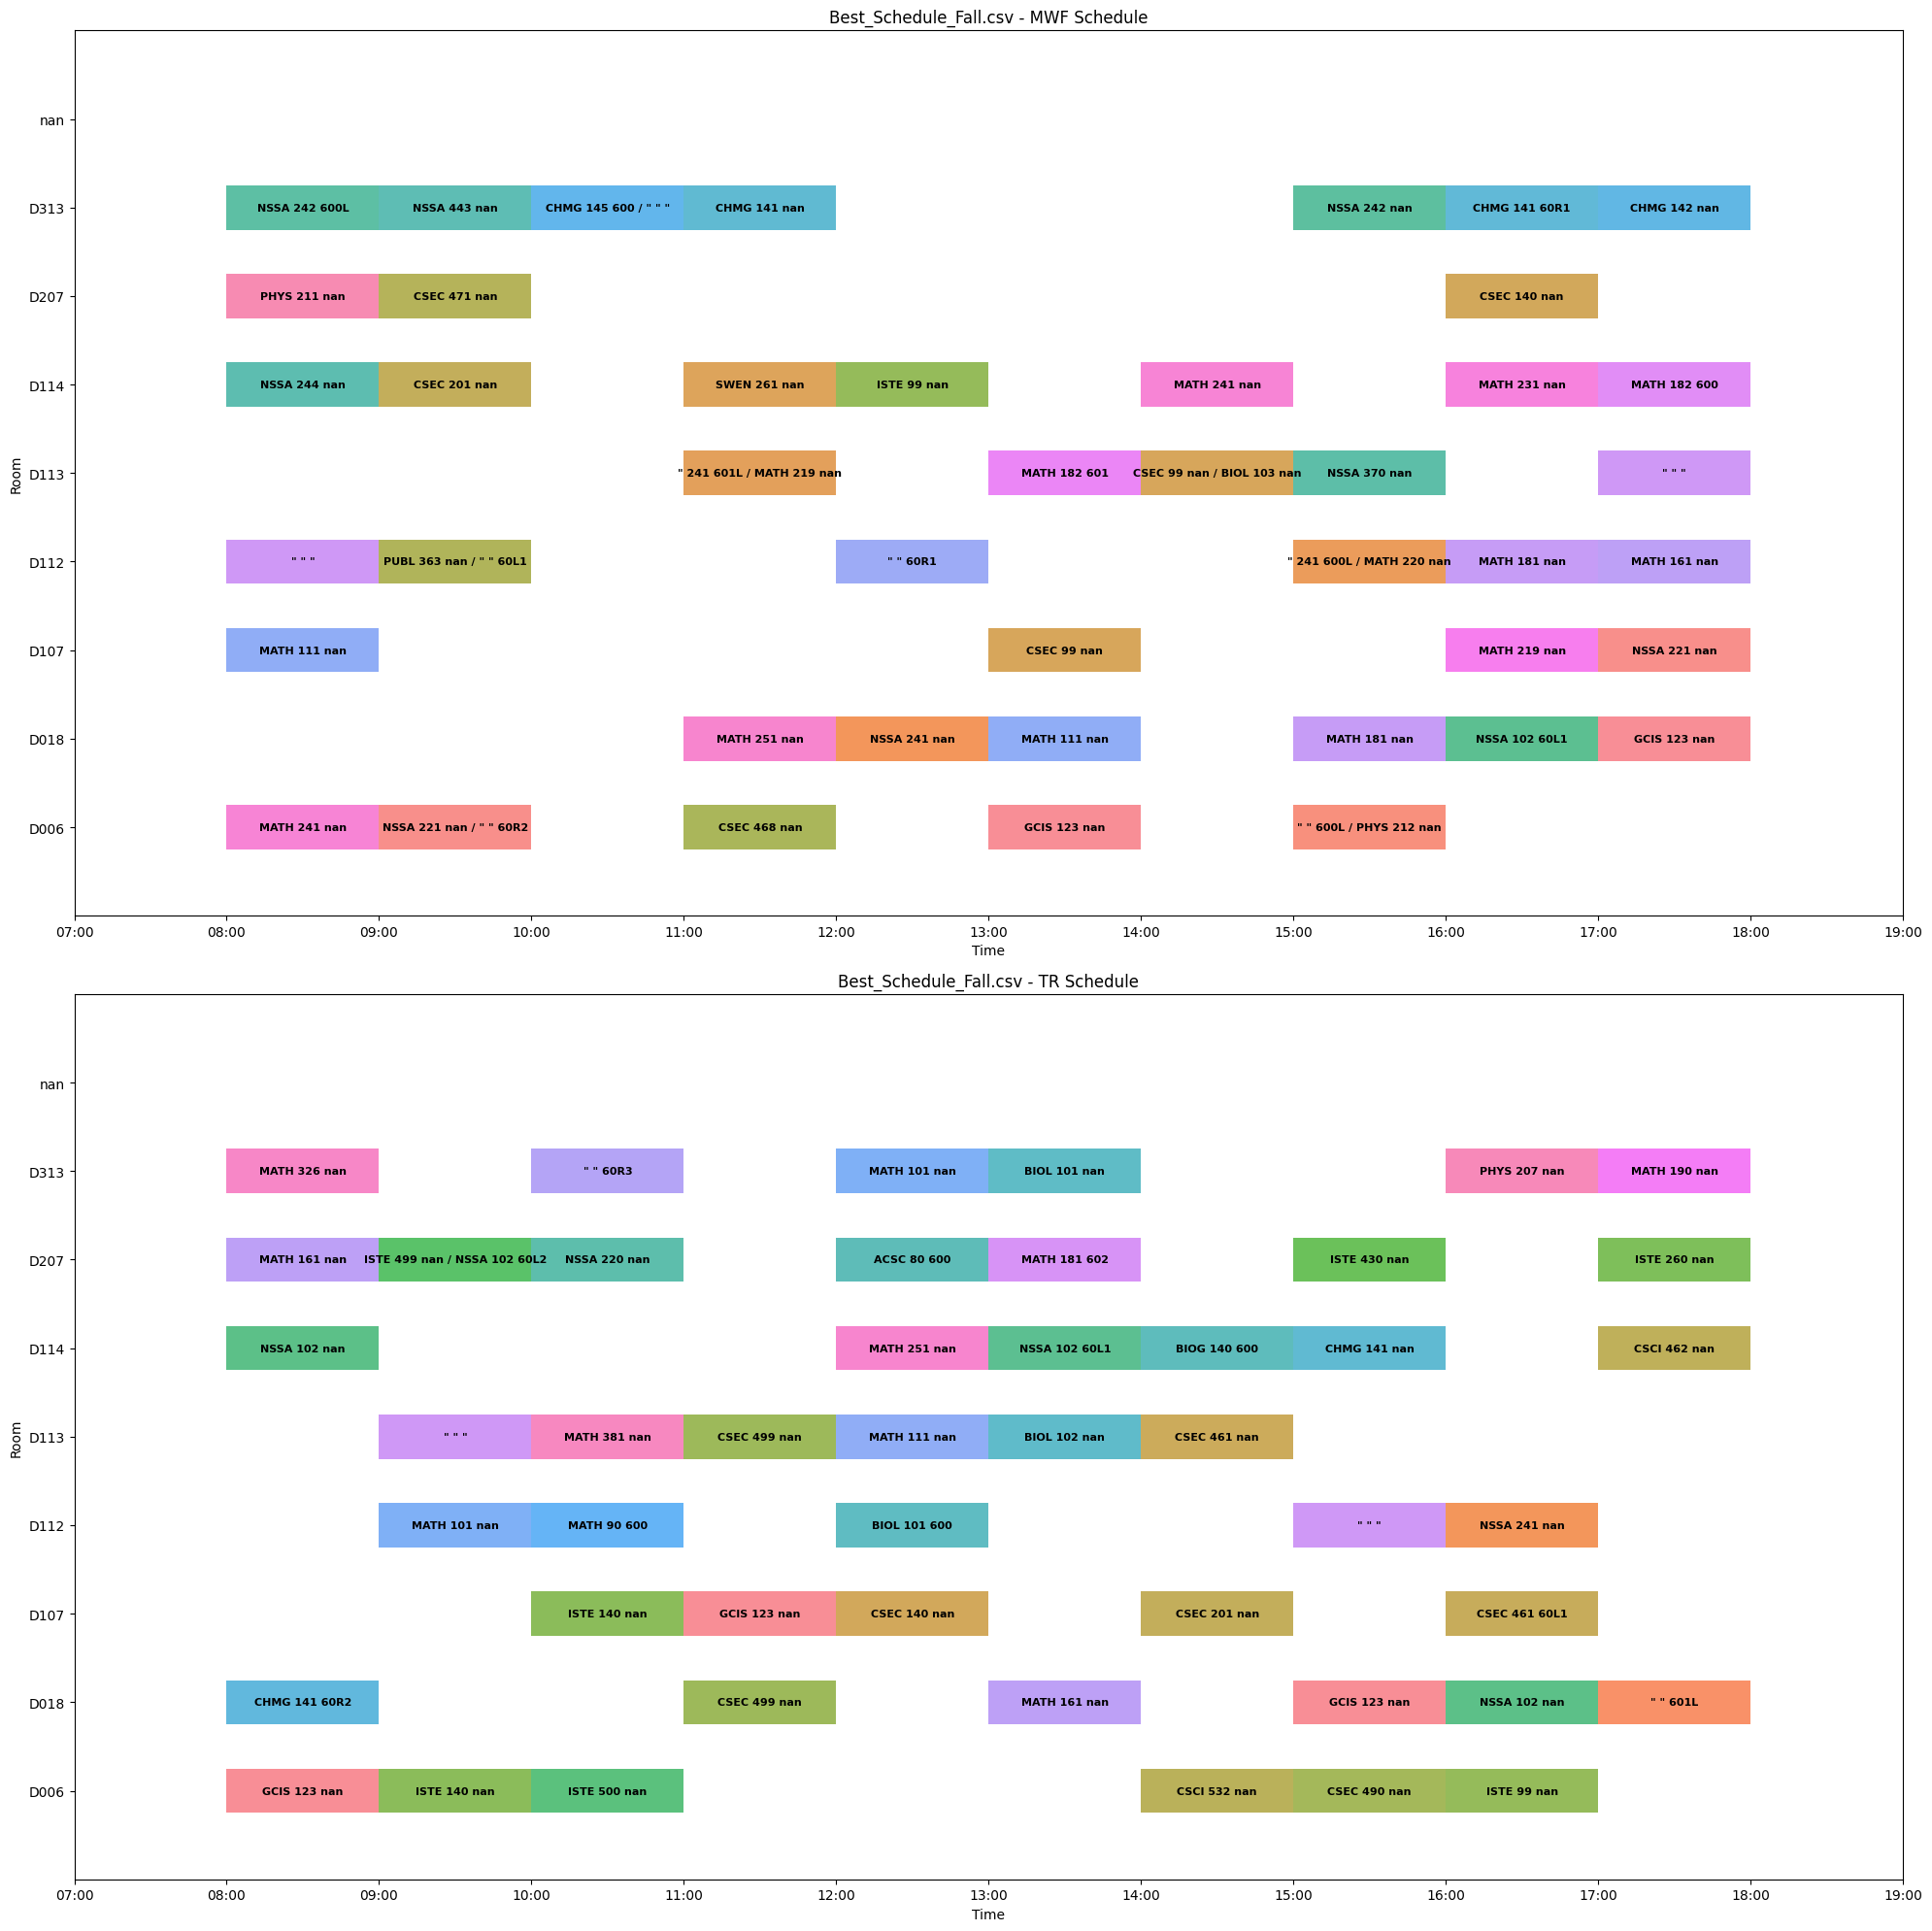

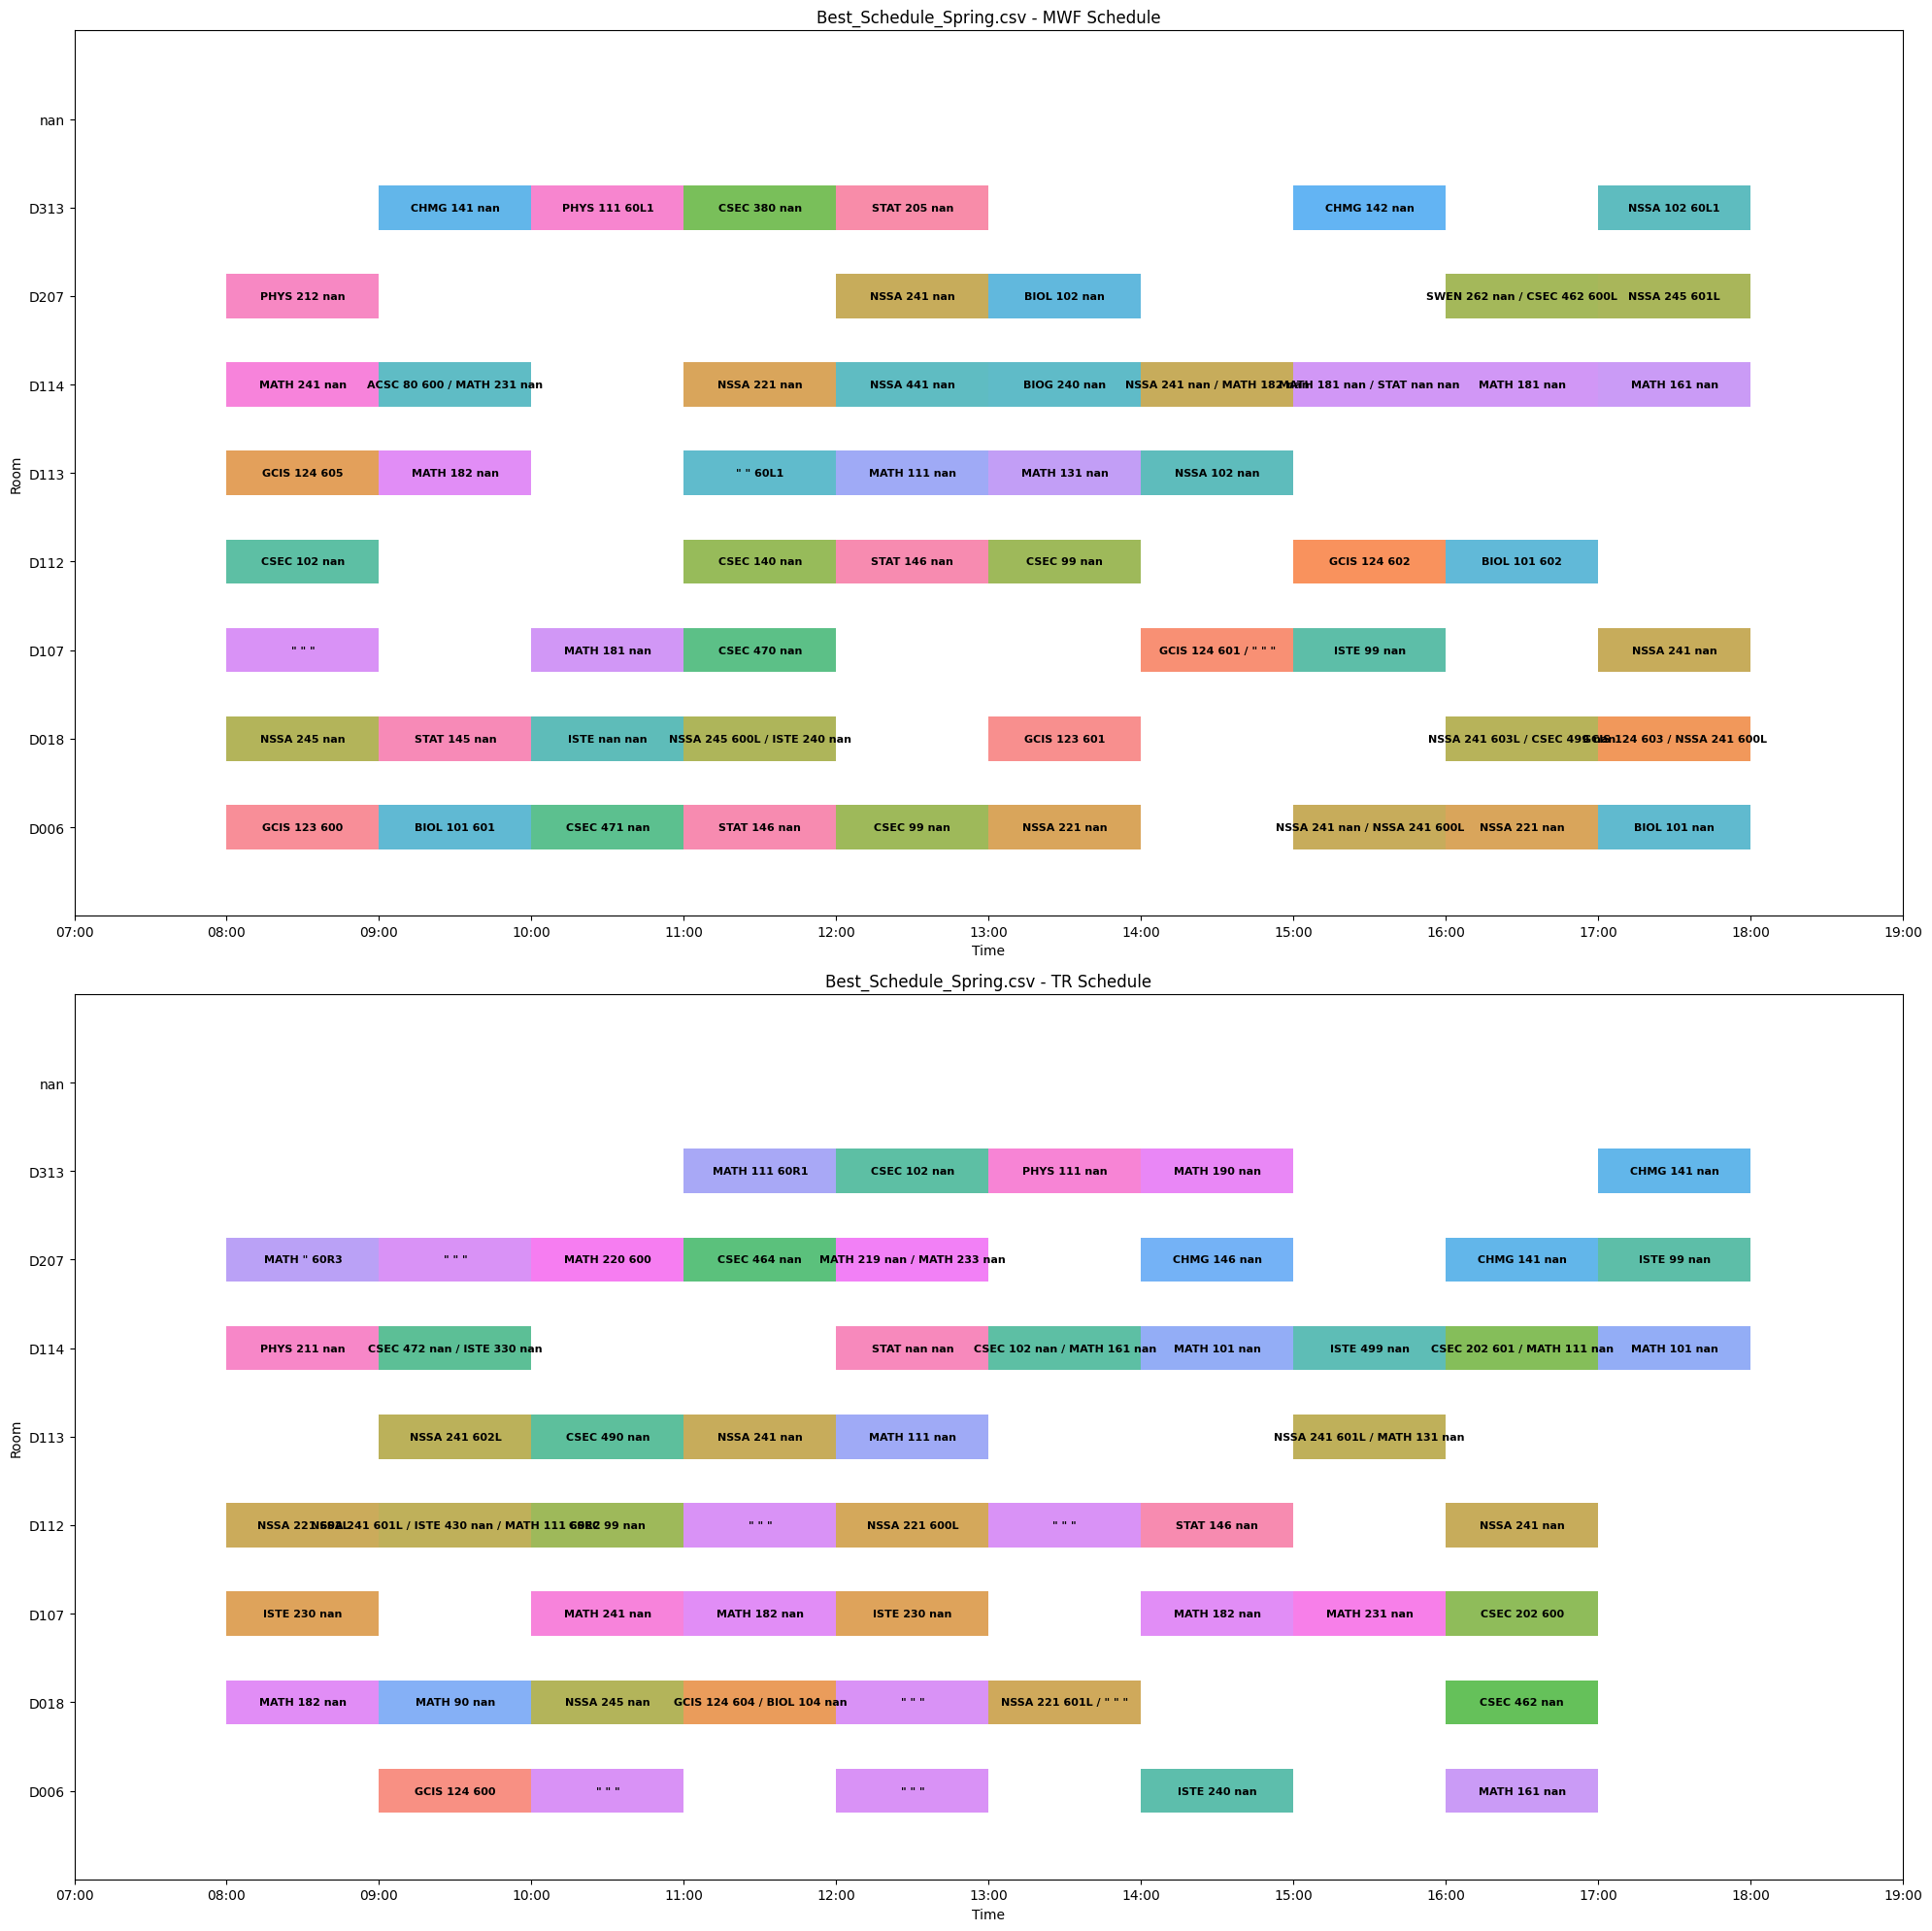

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

def visualize_schedule(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Convert time strings to datetime objects
    df['Time Start'] = pd.to_datetime(df['Time Start'], format='%H:%M').dt.time
    df['Time End'] = pd.to_datetime(df['Time End'], format='%H:%M').dt.time
    
    # Create a unique identifier for each class
    df['Class'] = df['Subject'] + ' ' + df['Cat#'].astype(str) + ' ' + df['Sect#'].astype(str)
    
    # Handle mixed data types in 'Room #' column
    df['Room #'] = df['Room #'].astype(str)
    
    # Create a list of all unique rooms, excluding NaN values
    rooms = sorted(df['Room #'].dropna().unique())
       
    # Create a color palette
    color_palette = sns.color_palette("husl", n_colors=len(df['Class'].unique()))
    color_dict = dict(zip(df['Class'].unique(), color_palette))
    
    # Separate data for MWF and TR
    df_mwf = df[df['Days'].isin(['M', 'W', 'F', 'MWF'])]
    df_tr = df[df['Days'].isin(['T', 'R', 'TR'])]
    
    # Function to plot for a specific day group
    def plot_day_group(day_df, ax, title):
        # Create a dictionary to store overlapping classes
        overlaps = {}
        
        # Plot each class as a rectangle with labels inside
        for _, row in day_df.iterrows():
            if pd.notna(row['Room #']) and pd.notna(row['Time Start']) and pd.notna(row['Time End']):
                start = datetime.combine(datetime.today(), row['Time Start'])
                end = datetime.combine(datetime.today(), row['Time End'])
                duration = (end - start).total_seconds() / 3600  # duration in hours
                
                # Check for overlaps
                key = (row['Room #'], start.hour + start.minute/60, end.hour + end.minute/60)
                if key in overlaps:
                    overlaps[key].append(row['Class'])
                else:
                    overlaps[key] = [row['Class']]
        
        # Plot the classes, combining overlaps
        for (room, start, end), classes in overlaps.items():
            duration = end - start
            rect = ax.barh(room, duration, left=start, height=0.5, align='center', 
                    color=color_dict[classes[0]], alpha=0.8)
            
            # Add text label inside the rectangle
            rx, ry = rect[0].get_xy()
            cx = rx + rect[0].get_width()/2.0
            cy = ry + rect[0].get_height()/2.0
            label = ' / '.join(classes)
            ax.text(cx, cy, label, ha='center', va='center', rotation=0, 
                    fontsize=8, color='black', fontweight='bold')
        
        # Customize the plot
        ax.set_ylim(-1, len(rooms))
        ax.set_xlim(7, 19)  # Assuming classes are between 7 AM and 7 PM
        ax.set_yticks(range(len(rooms)))
        ax.set_yticklabels(rooms)
        ax.set_xlabel('Time')
        ax.set_ylabel('Room')
        ax.set_title(title)
        
        # Add x-axis labels for each hour
        ax.set_xticks(range(7, 20))
        ax.set_xticklabels([f'{h:02d}:00' for h in range(7, 20)])
    
    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
    
    # Plot MWF schedule
    plot_day_group(df_mwf, ax1, f'{file_path} - MWF Schedule')
    
    # Plot TR schedule
    plot_day_group(df_tr, ax2, f'{file_path} - TR Schedule')
    
    plt.tight_layout()
    plt.show()

# Call the function with the path to your CSV files
visualize_schedule('Best_Schedule_Fall.csv')
visualize_schedule('Best_Schedule_Spring.csv')
